In [297]:
import cv2
import matplotlib.pyplot as plt
import numpy
import time
import math

In [298]:
# function used to determine the next states 
def determine(x,maxlenx,maxleny):
    if x[0]<0 or x[0]>=maxlenx or x[1]<0 or x[1]>=maxleny:
        return True
    
# function used to determine whether the next states are relevant to the patch or not    
def possneigh(imgin,i,j,maxlenx,maxleny):
    poss_n=[(i+1,j),(i,j+1),(i+1,j+1),(i-1,j-1),(i-1,j),(i,j-1),(i-1,j+1),(i+1,j-1)]
    poss_n=[x for x in poss_n if not determine(x,maxlenx,maxleny)]
    return [x for x in poss_n if imgin[x[0]][x[1]]==0]

#bfs from ex2 modified to work on image
def bfs_4(graph,start):
    visited = [] # List to keep track of visited nodes.
    queue = []     #Initialize a queue
    visited.append(start)
    queue.append(start)

    while queue:
        s = queue.pop(0) 
        
        for neighbour in possneigh(graph,s[0],s[1],graph.shape[0],graph.shape[1]):
            if neighbour not in visited:
                visited.append(neighbour)
                queue.append(neighbour)
    return visited

#dfs from ex2 modified to work on image
def dfs_4(graph,start):       
        visited = []
 
        # Create a stack for DFS
        stack = []
 
        # Push the current source node.
        stack.append(start)
 
        while (len(stack)):
            # Pop a vertex from stack and print it
            s = stack[-1]
            stack.pop()
 
            # Stack may contain same vertex twice. So
            # we need to print the popped item only
            # if it is not visited.
            if s not in visited:
#                 print(s,end=' ')
                visited.append(s)
 
            # Get all adjacent vertices of the popped vertex s
            # If a adjacent has not been visited, then push it
            # to the stack.
#             if s not in graph.keys():
#                 continue
            for node in possneigh(graph,s[0],s[1],graph.shape[0],graph.shape[1]):
                if node not in visited:
                    stack.append(node)
        return visited

In [299]:
img=cv2.imread("lane.png")

In [300]:
img_orig=cv2.cvtColor(img,cv2.COLOR_HSV2RGB)

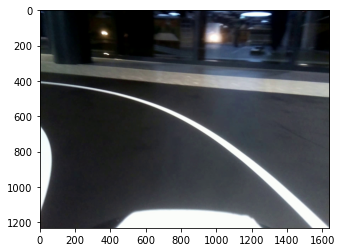

In [301]:
plt.imshow(img_orig)

In [302]:
import numpy as np
lower = np.array([0, 0, 249], np.uint8)
upper = np.array([120, 90, 255], np.uint8)

mask = cv2.inRange(img, lower, upper)

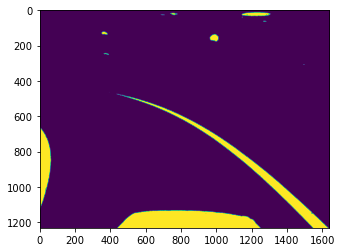

In [303]:
plt.imshow(mask)

In [313]:
# Creating kernel
kernel = np.ones((101, 101), np.uint8)
# Using cv2.erode() method 
image = cv2.dilate(mask, kernel) 

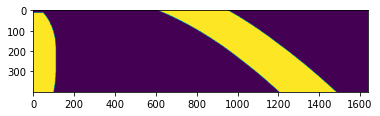

In [314]:
plt.imshow(image[600:1000,])
img_new=image[600:1000,]

(12, 49)


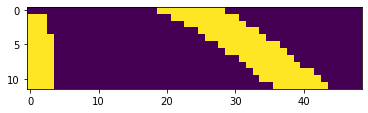

In [315]:
img_new=cv2.resize(img_new,None,fx=0.03,fy=0.03,interpolation = cv2.INTER_NEAREST)
plt.imshow(img_new)
print(img_new.shape)

In [316]:
def get_road_ratio(mask_img):
    mask=mask_img.copy()
    kernel = np.ones((111, 111), np.uint8)
    img_new = cv2.dilate(mask, kernel) 
    img_new=cv2.resize(img_new,None,fx=0.035,fy=0.035,interpolation = cv2.INTER_NEAREST)
    
    for i in range(img_new.shape[0]):
        for j in range(img_new.shape[1]):
            if img_new[i][j]>200:
                img_new[i][j]=1
            else:
                img_new[i][j]=0
    visited=bfs_4(img_new,(img_new.shape[0],img_new.shape[1]//2))
    right=len([i for i in visited if i[1]>img_new.shape[1]//2])
    print(img_new.shape[1]//2)
    left=len(visited)-right
    print("Len of Halfs: ",right," ",left)
    return (right-left)/len(visited)*36 , visited

    
    
    

In [318]:
mask_new=mask[600:1000,]
intime=time.time()
a,b=get_road_ratio(mask_new)
outtime=time.time()
print(outtime-intime)

28
Len of Halfs:  65   340
0.029494524002075195


In [319]:
x,y=zip(*b)

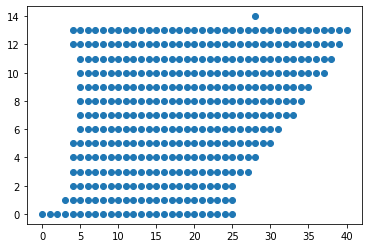

In [320]:
plt.scatter(y,x)

In [321]:
a

-24.444444444444446

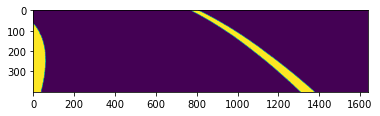

In [322]:
plt.imshow(mask_new)

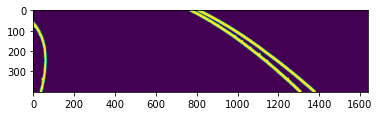

In [323]:
out_img=cv2.Canny(mask_new,0,200)
kernel = np.ones((11, 11), np.uint8)
out_new = cv2.dilate(out_img, kernel) 
plt.imshow(out_new)

In [324]:
cdst=np.ones(out_new.shape)
lines=cv2.HoughLines(out_new,1, np.pi / 180, 200,min_theta=math.pi/8,max_theta=7*math.pi/8)


In [325]:
def average_slope_intercept(frame, line_segments):
    """
    This function combines line segments into one or two lane lines
    If all line slopes are < 0: then we only have detected left lane
    If all line slopes are > 0: then we only have detected right lane
    """
    lane_lines = []
    if line_segments is None:
        # print("No line_segment segments detected")
        return lane_lines

    height, width, _ = frame.shape
    left_fit = []
    right_fit = []

    boundary = 1 / 2
    # left lane line segment should be on left 2/3 of the screen
    left_region_boundary = width * (1 - boundary)
    # right lane line segment should be on left 2/3 of the screen
    right_region_boundary = width * boundary

    for line_segment in line_segments:
        for x1, y1, x2, y2 in line_segment:
            if x1 == x2:
                continue
            fit = np.polyfit((x1, x2), (y1, y2), 1)
            slope = fit[0]
            intercept = fit[1]
            if slope < 0:
                if x1 < left_region_boundary and x2 < left_region_boundary:
                    left_fit.append((slope, intercept))
            else:
                if x1 > right_region_boundary and x2 > right_region_boundary:
                    right_fit.append((slope, intercept))

    left_fit_average = np.average(left_fit, axis=0)
    if len(left_fit) > 0:
        lane_lines.append(make_points(frame, left_fit_average))

    right_fit_average = np.average(right_fit, axis=0)
    if len(right_fit) > 0:
        lane_lines.append(make_points(frame, right_fit_average))
    return lane_lines
    # return lane_lines, left_fit_average, right_fit_average